In [16]:
# Importing necessities for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from functools import partial
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
import joblib
from imblearn.ensemble import BalancedBaggingClassifier


In [17]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [18]:
# Loading the data
df_churn=pd.read_csv('data/Churn_prepared.csv',index_col='customerID')

In [19]:

rf_model = joblib.load('random_forest_model.pkl')
logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svc_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
mlp_model = joblib.load('mlp_model.pkl')
gnb_model = joblib.load('naive_bayes_model.pkl')

models=[rf_model,logreg_model,svm_model,xgb_model,mlp_model,gnb_model]
model_names = ['Random Forest', 'Logistic Regression', 'SVC', 'XGBoost', 'MLP', 'Naive Bayes']


In [20]:
# Define models
models = [rf_model, logreg_model, svm_model, xgb_model, mlp_model, gnb_model]
model_names = ['Random Forest', 'Logistic Regression', 'SVC', 'XGBoost', 'MLP', 'Naive Bayes']

# target and features
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a list to hold the BalancedBaggingClassifier models with different estimators
bb_classifiers = [
    BalancedBaggingClassifier(estimator=rf_model, n_estimators=10, random_state=1, n_jobs=-1),
    BalancedBaggingClassifier(estimator=logreg_model, n_estimators=10, random_state=1, n_jobs=-1),
    BalancedBaggingClassifier(estimator=svm_model, n_estimators=10, random_state=1, n_jobs=-1),
    BalancedBaggingClassifier(estimator=xgb_model, n_estimators=10, random_state=1, n_jobs=-1),
    BalancedBaggingClassifier(estimator=mlp_model, n_estimators=10, random_state=1, n_jobs=-1),
    BalancedBaggingClassifier(estimator=gnb_model, n_estimators=10, random_state=1, n_jobs=-1),
]


models += bb_classifiers
model_names += [
    'BB Random Forest', 'BB Logistic Regression', 'BB SVC', 'BB XGBoost', 'BB MLP', 'BB Naive Bayes'
]

results = pd.DataFrame(columns=['Model', 'Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score', 'Mean ROC AUC', 'Best Threshold'])

# Evaluate each model 
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']:  # Check if scaling is needed
        X_data = X_train_scaled
    else:  
        X_data = X_train

    # Cross-validate model
    cv_accuracy = cross_val_score(model, X_data, y_train, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(model, X_data, y_train, cv=5, scoring='precision')
    cv_recall = cross_val_score(model, X_data, y_train, cv=5, scoring='recall')
    cv_f1 = cross_val_score(model, X_data, y_train, cv=5, scoring='f1')
    cv_roc_auc = cross_val_score(model, X_data, y_train, cv=5, scoring='roc_auc')

    # Fit the model on the full training data to get probabilities
    model.fit(X_data, y_train)
    y_probs = model.predict_proba(X_data)[:, 1]  # Get probabilities for the positive class

    # Determine best threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_probs)

    # Choose the threshold that maximizes F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Store mean metrics and the best threshold
    new_result = pd.DataFrame({
        'Model': [name],
        'Mean Accuracy': [cv_accuracy.mean()],
        'Mean Precision': [cv_precision.mean()],
        'Mean Recall': [cv_recall.mean()],
        'Mean F1 Score': [cv_f1.mean()],
        'Mean ROC AUC': [cv_roc_auc.mean()],
        'Best Threshold': [best_threshold]
    })

    results = pd.concat([results, new_result], ignore_index=True)



C:\Users\Admin\AppData\Local\Temp\ipykernel_1140\2156045785.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1140\2156045785.py:57: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [21]:
results = results.sort_values(by='Mean F1 Score', ascending=False)
results

,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1 Score,Mean ROC AUC,Best Threshold
6,BB Random Forest,0.761803,0.530445,0.787372,0.633466,0.850544,0.539650
9,BB XGBoost,0.753283,0.518607,0.803012,0.629889,0.851709,0.637316
5,Naive Bayes,0.743522,0.506280,0.800277,0.620008,0.836580,0.800483
11,BB Naive Bayes,0.719737,0.479341,0.828818,0.607309,0.836691,0.911448
1,Logistic Regression,0.809727,0.660964,0.560438,0.605774,0.848029,0.307764
3,XGBoost,0.809905,0.677353,0.522410,0.588544,0.851462,0.366151
4,MLP,0.803334,0.649555,0.538702,0.587963,0.845504,0.370320
2,SVC,0.804402,0.661526,0.521056,0.581440,0.839807,0.305257
0,Random Forest,0.807242,0.681247,0.495900,0.567387,0.850204,0.342668
7,BB Logistic Regression,0.650517,0.414038,0.810458,0.547836,0.790412,0.875653


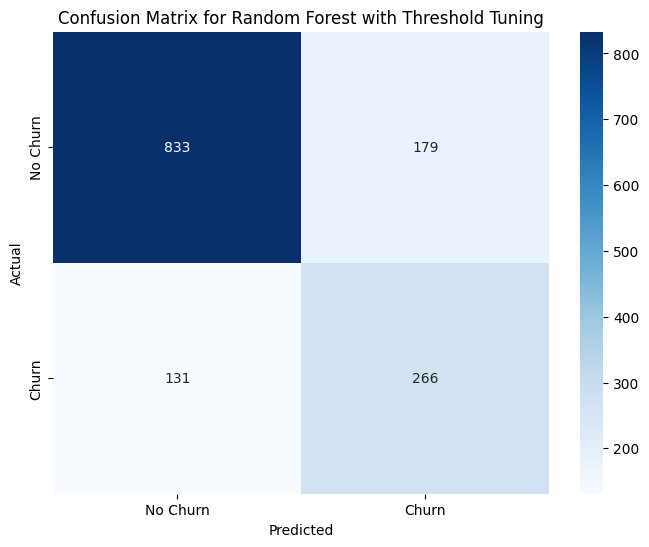

Classification Report for Random Forest with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1012
           1       0.60      0.67      0.63       397

    accuracy                           0.78      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.79      0.78      0.78      1409



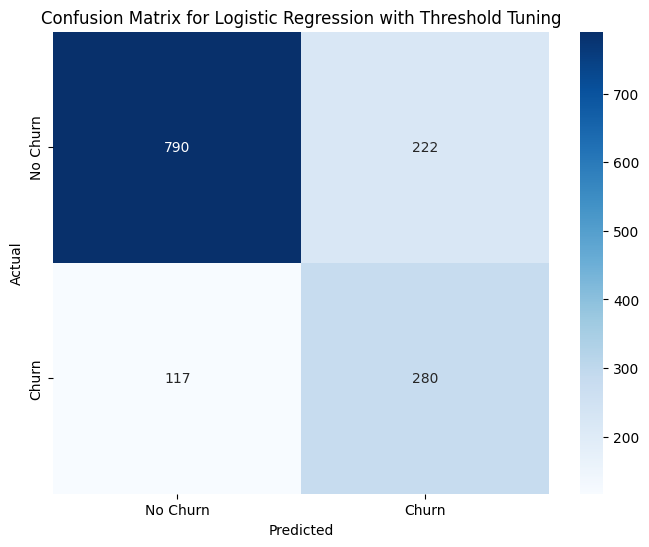

Classification Report for Logistic Regression with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1012
           1       0.56      0.71      0.62       397

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.78      0.76      0.77      1409



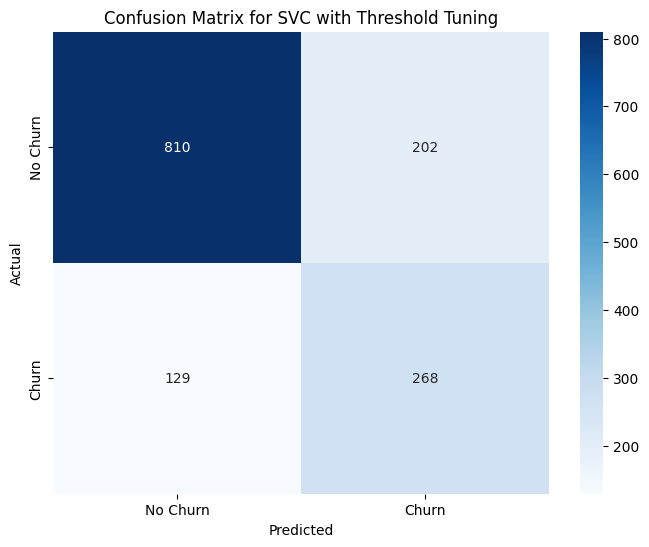

Classification Report for SVC with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1012
           1       0.57      0.68      0.62       397

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.78      0.77      0.77      1409



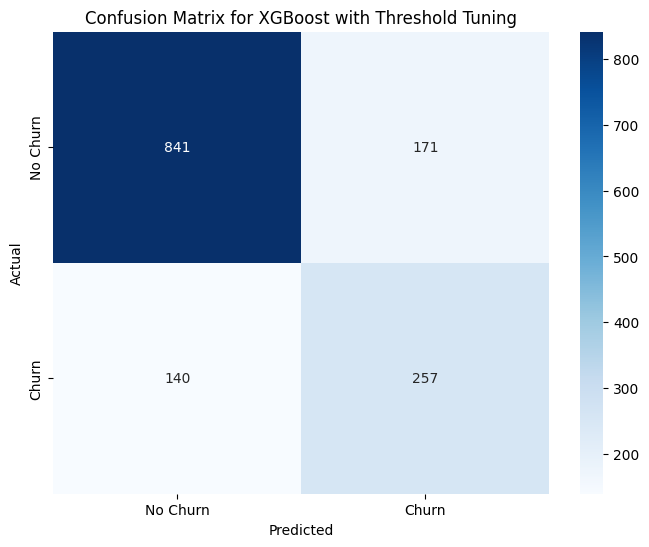

Classification Report for XGBoost with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1012
           1       0.60      0.65      0.62       397

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.78      0.78      0.78      1409



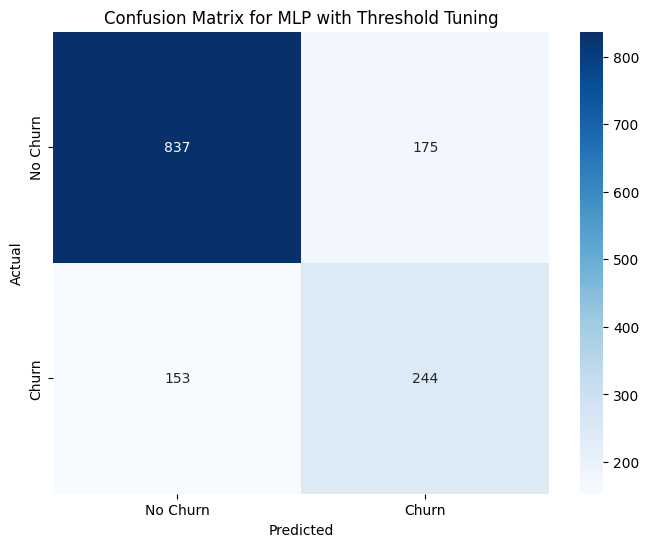

Classification Report for MLP with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1012
           1       0.58      0.61      0.60       397

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.77      0.77      0.77      1409



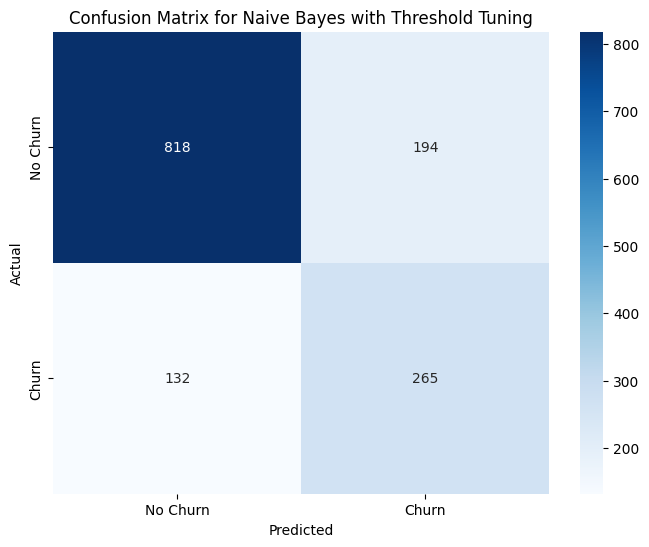

Classification Report for Naive Bayes with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1012
           1       0.58      0.67      0.62       397

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.78      0.77      0.77      1409



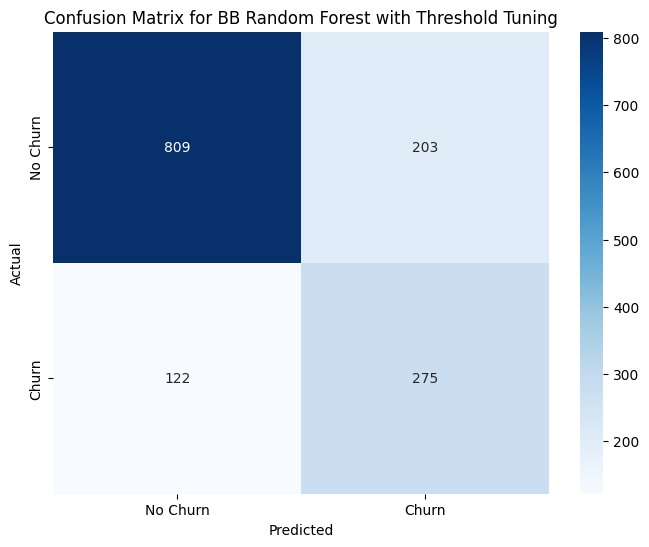

Classification Report for BB Random Forest with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1012
           1       0.58      0.69      0.63       397

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



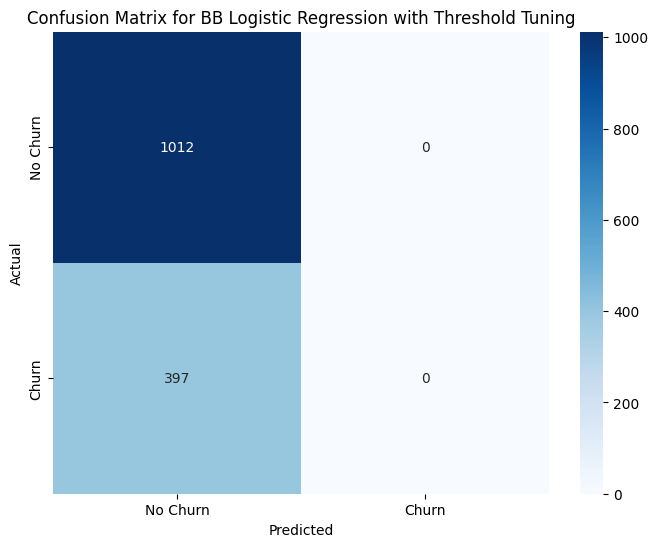

c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classification Report for BB Logistic Regression with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1012
           1       0.00      0.00      0.00       397

    accuracy                           0.72      1409
   macro avg       0.36      0.50      0.42      1409
weighted avg       0.52      0.72      0.60      1409



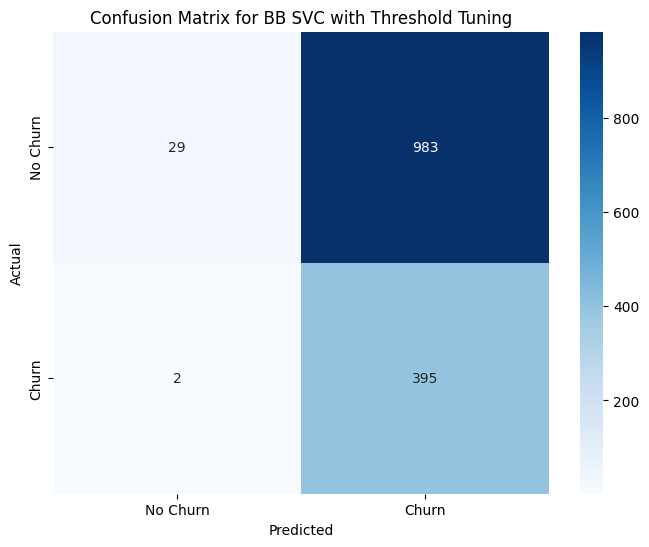

Classification Report for BB SVC with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.94      0.03      0.06      1012
           1       0.29      0.99      0.45       397

    accuracy                           0.30      1409
   macro avg       0.61      0.51      0.25      1409
weighted avg       0.75      0.30      0.17      1409



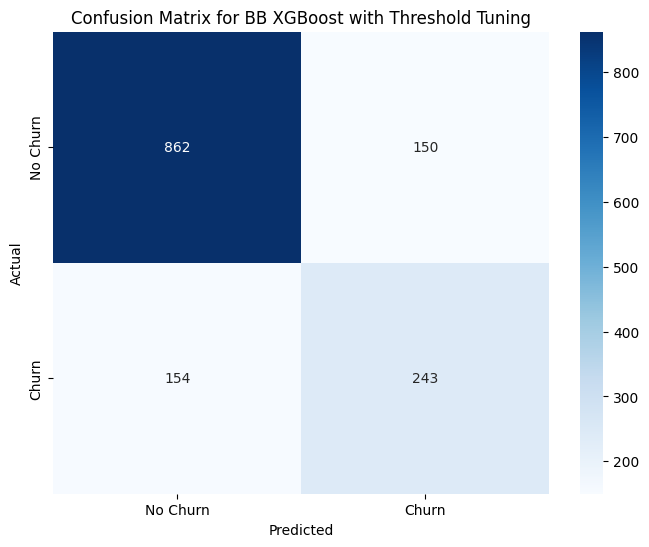

Classification Report for BB XGBoost with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1012
           1       0.62      0.61      0.62       397

    accuracy                           0.78      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.78      0.78      0.78      1409



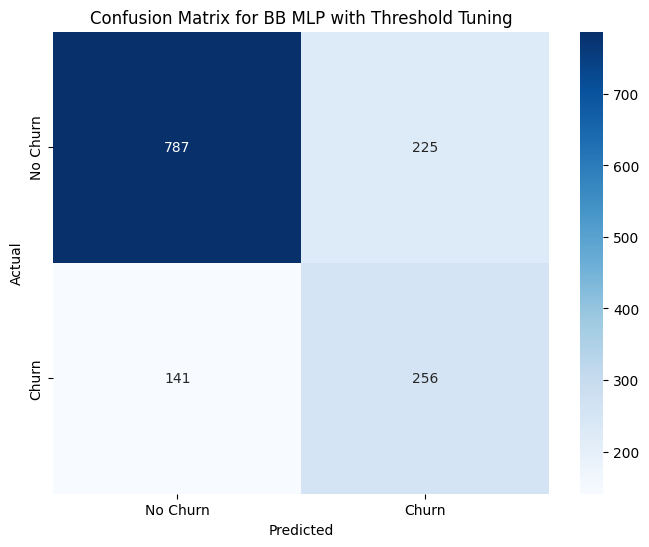

Classification Report for BB MLP with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1012
           1       0.53      0.64      0.58       397

    accuracy                           0.74      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.76      0.74      0.75      1409



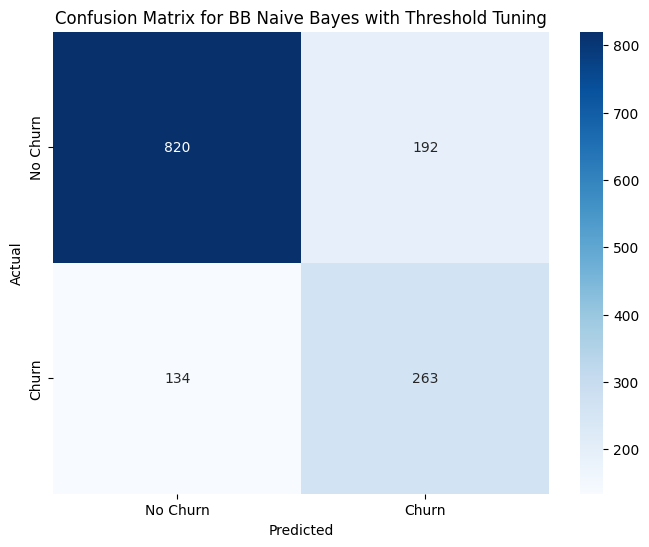

Classification Report for BB Naive Bayes with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1012
           1       0.58      0.66      0.62       397

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.78      0.77      0.77      1409



In [22]:
# predictions with the best threshold
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']:
        model.fit(X_train_scaled, y_train)
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]

    # Apply the best threshold
    y_pred_adjusted = (y_probs >= results.loc[results['Model'] == name, 'Best Threshold'].values[0]).astype(int)

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name} with Threshold Tuning')
    plt.show()

    class_report = classification_report(y_test, y_pred_adjusted)
    print(f'Classification Report for {name} with Threshold Tuning:\n')
    print(class_report)
